# CATE Estimation
- This notebook is an investigation into how the efficacy of drains in preventing the recurrence of CSDH conditional on patient/treatment factors
- Double Machine Learning (DML) CATE estimators from the EconML library (LinearDML and DML) are considered
- Doubly Robust CATE estimators unfortunately had to be ignored due to the lack of support for binary outcome variables in the DoWhy package

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor


# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.dr import DRLearner, ForestDRLearner, LinearDRLearner
from econml.dml import LinearDML, CausalForestDML, SparseLinearDML, NonParamDML, DML
from econml.inference import BootstrapInference
from econml.cate_interpreter import SingleTreeCateInterpreter

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Custom DoWhy helper functions
from pathlib import Path
import os
import sys
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_burr.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

## Data Pre-Processing

In [3]:
# DOCTOR DAG features
doc_features = ['age', 'stroke', 'ihd', 'metalvalve', 'antiplatelet', 'warfarin', 'hospital',
                'thickness_sum', 'density', 'optype', 'membranes', 'burrhole_num', 'bedrest',
                'drain', 'recurrence']
csdh = csdh[doc_features]
            
# Categorical type conversion
categorical_features = ['optype', 'hospital', 'bedrest', 'density',  'burrhole_num', 'bedrest']

binary_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'recurrence',
                   'drain', 'warfarin', 'membranes']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes
    
for feature in binary_features:
    csdh[feature] = csdh[feature].astype(int)

---
## 0. Naïve ATE Estimation (no causal inference)

In [4]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.08374644024891888


---
## DAG under consideration

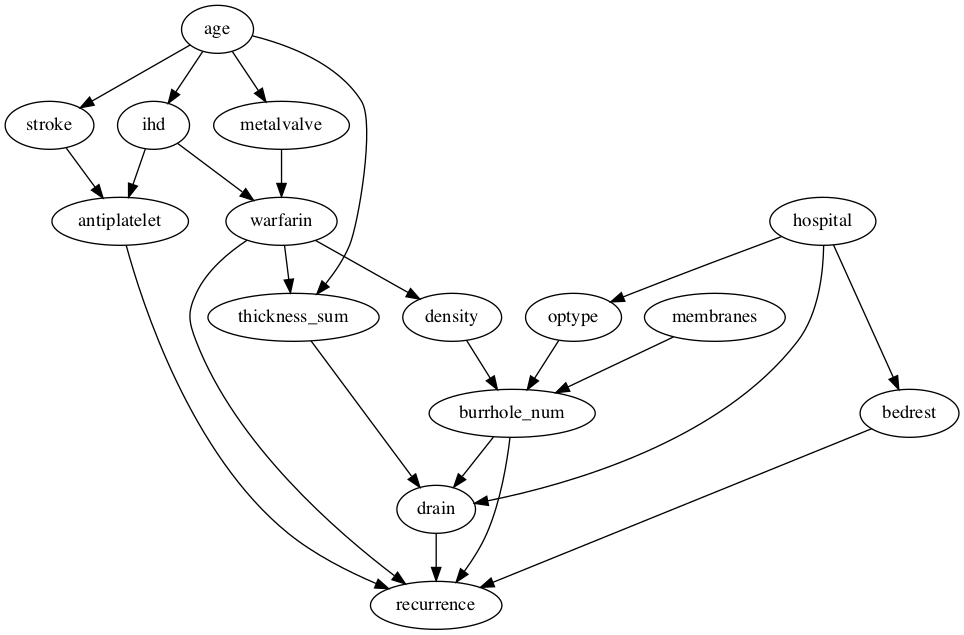

In [5]:
doc_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
doc_model.view_model()
display(Image(filename="causal_model.png"))

---
## Treatment factors investigation

### Models:
- LinearDML
- DML

In [6]:
# Define treatment, outcome, confounders
confounders = ['hospital', 'antiplatelet', 'metalvalve', 'thickness_sum', 'ihd',
'warfarin', 'age', 'stroke', 'density', 'membranes']
conditional_features = ['burrhole_num', 'optype', 'bedrest']

T = csdh['drain'].values
Y = csdh['recurrence'].values
X = csdh[conditional_features].values
W = csdh[confounders].values

In [7]:
# Define "nuisance" models that resulted from hyperparameter tuning
model_propensity = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain', eval_metric="logloss",
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None)

model_regression = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain', eval_metric="logloss",
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1,
                               monotone_constraints='()', n_estimators=151,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None)

In [8]:
# Cross validation routine for `model_final` in DML and DRLearner
cv_reg = lambda: GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid={
                    'max_depth': [2, 5, 8, 12],
                    'n_estimators': np.arange(10, 200, 10).tolist(),
                    'max_features': ['sqrt', 'log2', None],
                    'random_state': [100],
                    'min_samples_leaf':[2, 5, 10, 50]
                }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
            )

In [9]:
treatment_linear_dml_est = LinearDML(model_y=dwh.RegWrapper(model_regression), 
                                     model_t=model_propensity,
                                     fit_cate_intercept=True,
                                     linear_first_stages=False,
                                     featurizer=PolynomialFeatures(degree=1, include_bias=False),
                                     random_state=100,
                                     cv=3,
                                     discrete_treatment=True,
                                     categories=[0,1])

In [10]:
treatment_dml_est = DML(model_y=dwh.RegWrapper(model_regression), 
                        model_t=model_propensity,
                        model_final=cv_reg(),
                        fit_cate_intercept=True,
                        linear_first_stages=False,
                        featurizer=PolynomialFeatures(degree=1, include_bias=False),
                        random_state=100,
                        cv=3,
                        discrete_treatment=True,
                        categories=[0,1])

In [11]:
# fit estimator through DoWhy (this maintains identification from the DAG)
treatment_linear_dml_est = treatment_linear_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                     outcome_names=["recurrence"], 
                                     treatment_names=["drain"], 
                                     feature_names=conditional_features,
                                     confounder_names=confounders,
                                     cache_values=True,
                                     graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

In [12]:
treatment_dml_est = treatment_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                     outcome_names=["recurrence"], 
                                     treatment_names=["drain"], 
                                     feature_names=conditional_features,
                                     confounder_names=confounders,
                                     cache_values=True,
                                     graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

In [13]:
treatment_linear_dml_est.score_

In [14]:
treatment_dml_est.score_

### Linear `model_final` achieves better final MSE retrain with larger `mc_iters`

In [15]:
# fit estimator through DoWhy (this maintains identification from the DAG)
treatment_linear_dml_est = LinearDML(model_y=dwh.RegWrapper(model_regression), 
                                     model_t=model_propensity,
                                     fit_cate_intercept=True,
                                     linear_first_stages=False,
                                     featurizer=PolynomialFeatures(degree=1, include_bias=False),
                                     random_state=100,
                                     cv=3,
                                     mc_iters=100,
                                     discrete_treatment=True,
                                     categories=[0,1])

treatment_linear_dml_est = treatment_linear_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                                              outcome_names=["recurrence"], 
                                                              treatment_names=["drain"], 
                                                              feature_names=conditional_features,
                                                              confounder_names=confounders,
                                                              cache_values=True,
                                                              graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

## Interpret and summarize model

In [16]:
print(treatment_linear_dml_est.identified_estimand_)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|optype,warfarin,antiplatelet,metalvalve,burrho
d[drain]                                                                      

                                                                        
le_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density,U) = P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: 

In [17]:
print(treatment_linear_dml_est.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|optype,warfarin,antiplatelet,metalvalve,burrho
d[drain]                                                                      

                                                                        
le_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density,U) = P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density)

## Realized estimand
b: recurrence~drain+opt

In [18]:
treatment_linear_dml_est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
burrhole_num,0.055,0.074,0.741,0.459,-0.067,0.176
optype,0.112,0.051,2.18,0.029,0.027,0.196
bedrest,0.001,0.031,0.045,0.964,-0.049,0.052
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.116,0.085,-1.368,0.171,-0.256,0.024


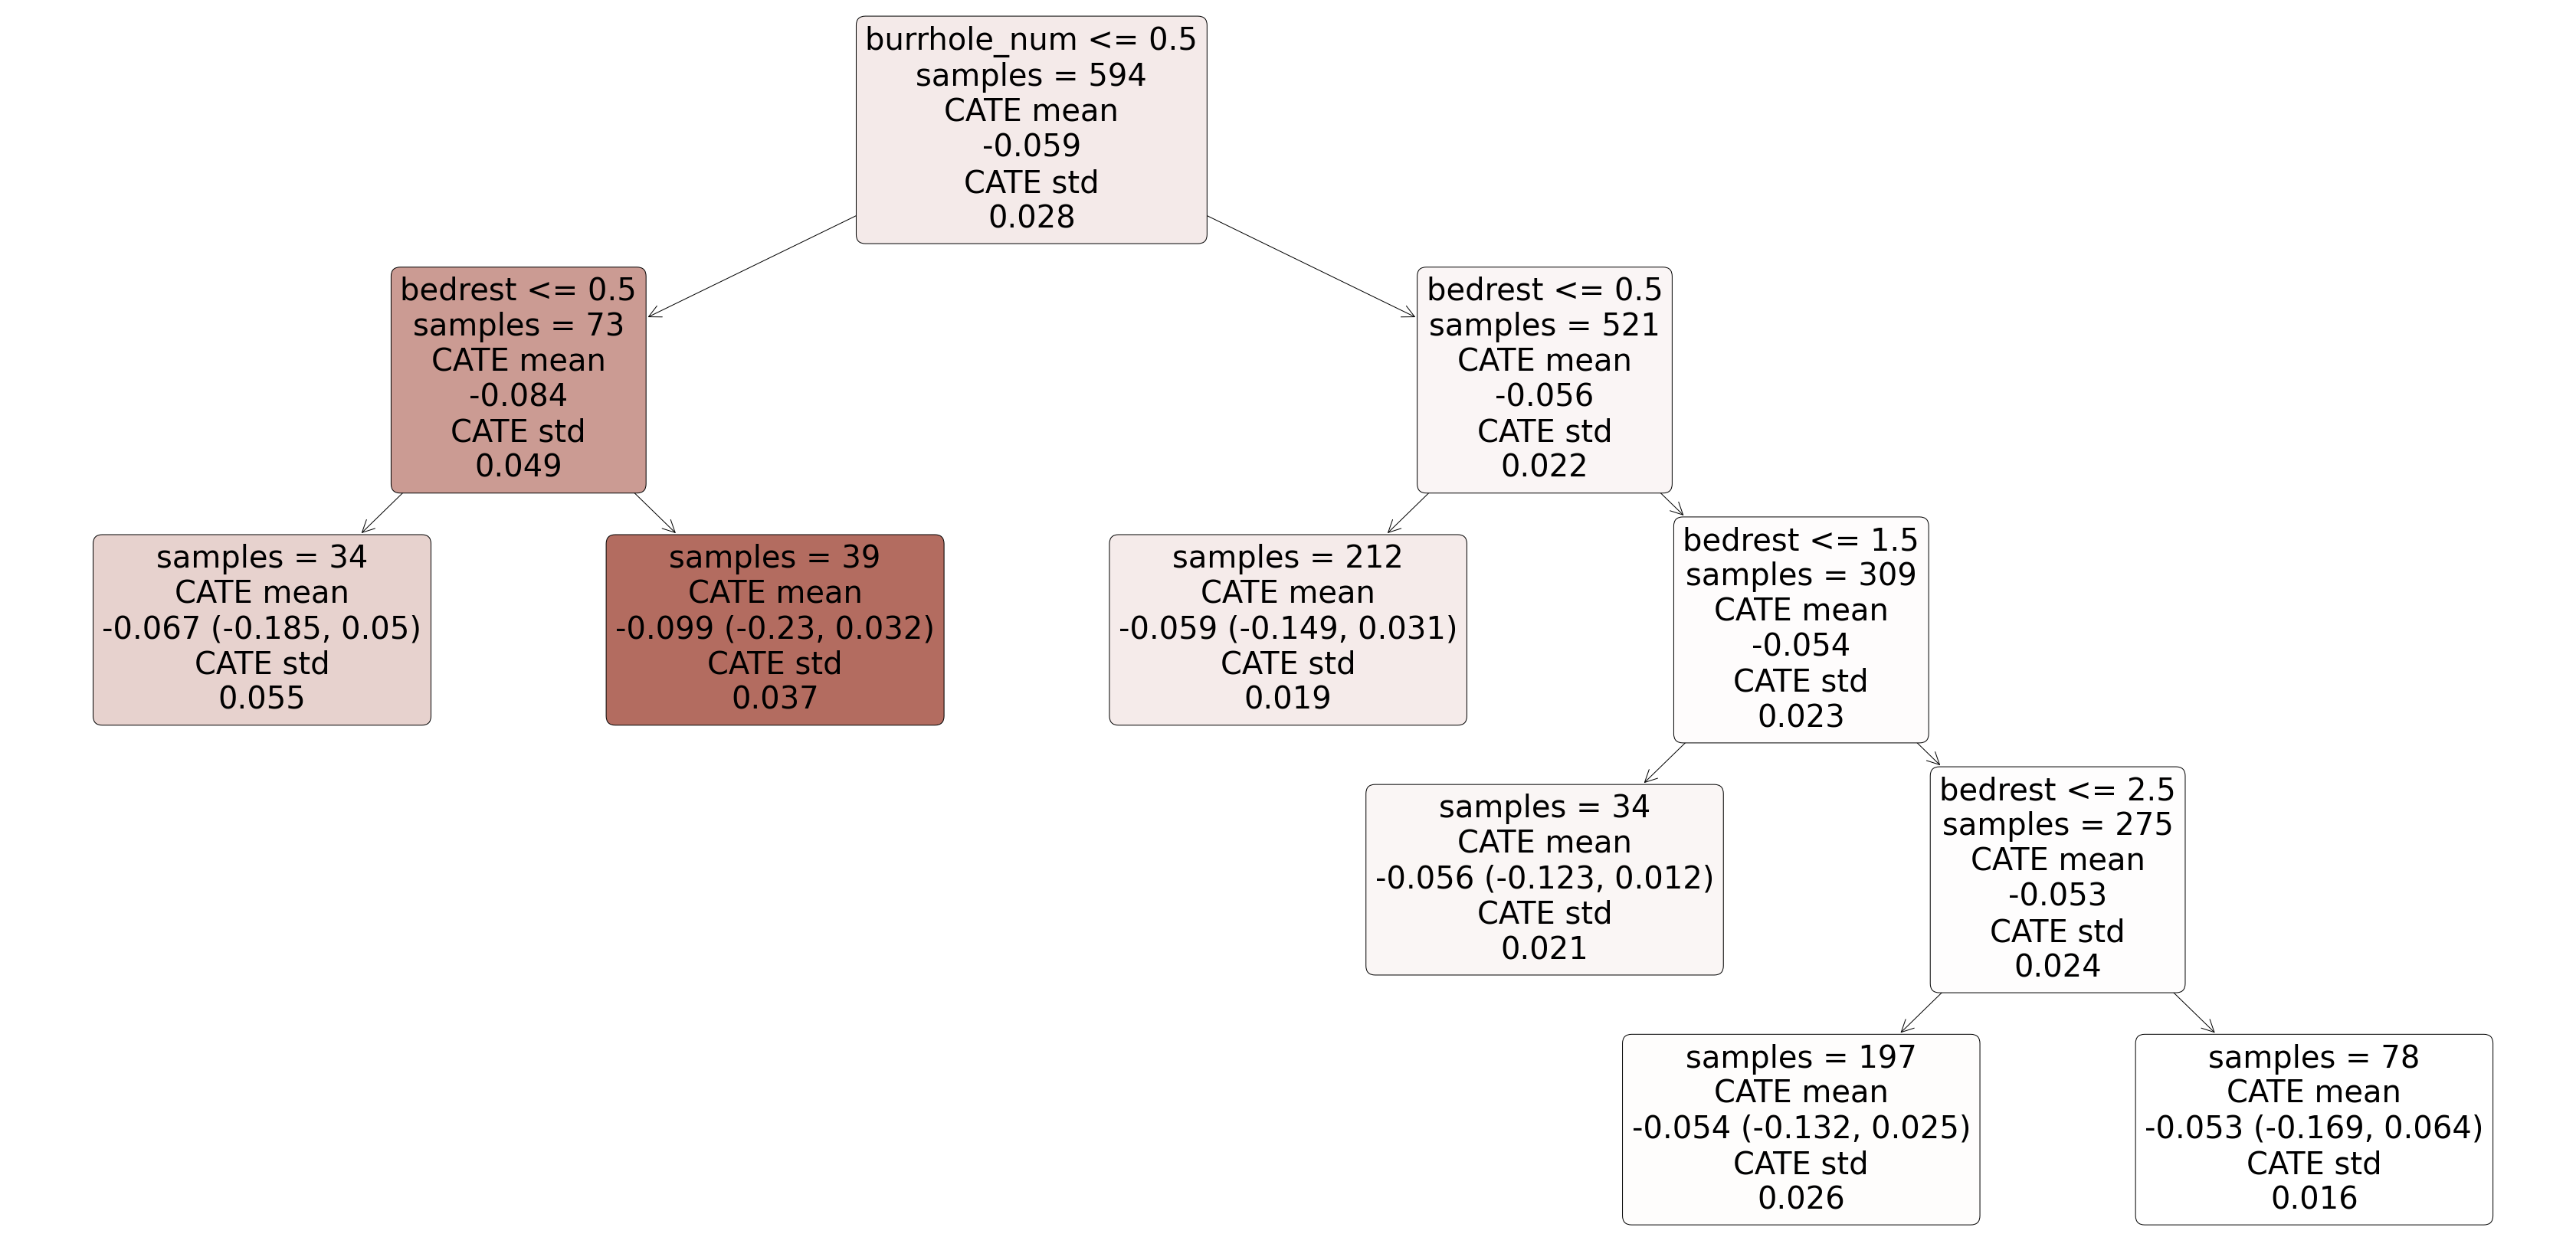

In [19]:
treatment_lin_intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=30)
treatment_lin_intrp.interpret(treatment_linear_dml_est, X)
plt.figure(figsize=(60, 30))
treatment_lin_intrp.plot(feature_names=conditional_features, fontsize=40)
plt.savefig('../output/figs/treatment_cate_tree.png', dpi=300)

---
# Patient Factors

In [20]:
# Define treatment, outcome, confounders
p_confounders = ['hospital', 'burrhole_num', 'optype', 'bedrest']
p_conditions = ['antiplatelet', 'metalvalve', 'ihd', 'thickness_sum', 
                'warfarin', 'stroke', 'density', 'membranes', 'age']

T = csdh['drain'].values
Y = csdh['recurrence'].values
X = csdh[p_conditions].values
W = csdh[p_confounders].values

In [21]:
patient_linear_dml_est = LinearDML(model_y=dwh.RegWrapper(model_regression), 
                                   model_t=model_propensity,
                                   fit_cate_intercept=True,
                                   linear_first_stages=False,
                                   featurizer=PolynomialFeatures(degree=1, include_bias=False),
                                   random_state=100,
                                   cv=3,
                                   discrete_treatment=True,
                                   categories=[0,1])

In [22]:
patient_dml_est = DML(model_y=dwh.RegWrapper(model_regression), 
                        model_t=model_propensity,
                        model_final=cv_reg(),
                        fit_cate_intercept=True,
                        linear_first_stages=False,
                        featurizer=PolynomialFeatures(degree=1, include_bias=False),
                        random_state=100,
                        cv=3,
                        discrete_treatment=True,
                        categories=[0,1])

In [23]:
# fit estimator through DoWhy (this maintains identification from the DAG)
patient_linear_dml_est = patient_linear_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                     outcome_names=["recurrence"], 
                                     treatment_names=["drain"], 
                                     feature_names=p_conditions,
                                     confounder_names=p_confounders,
                                     cache_values=True,
                                     graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

In [24]:
patient_dml_est = patient_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                     outcome_names=["recurrence"], 
                                     treatment_names=["drain"], 
                                     feature_names=p_conditions,
                                     confounder_names=p_confounders,
                                     cache_values=True,
                                     graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

In [25]:
patient_linear_dml_est.score_

In [26]:
patient_dml_est.score_

### Linear `model_final` achieves better final MSE retrain with larger `mc_iters`

In [27]:
# fit estimator through DoWhy (this maintains identification from the DAG)
patient_linear_dml_est = LinearDML(model_y=dwh.RegWrapper(model_regression), 
                                   model_t=model_propensity,
                                   fit_cate_intercept=True,
                                   linear_first_stages=False,
                                   featurizer=PolynomialFeatures(degree=1, include_bias=False),
                                   random_state=100,
                                   cv=3,
                                   mc_iters=100,
                                   discrete_treatment=True,
                                   categories=[0,1])

patient_linear_dml_est = patient_linear_dml_est.dowhy.fit(Y, T, X=X, W=W, 
                                                          outcome_names=["recurrence"], 
                                                          treatment_names=["drain"], 
                                                          feature_names=p_conditions,
                                                          confounder_names=p_confounders,
                                                          cache_values=True,
                                                          graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

## Interpret and summarize model

In [28]:
print(patient_linear_dml_est.identified_estimand_)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|optype,warfarin,antiplatelet,metalvalve,burrho
d[drain]                                                                      

                                                                        
le_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density,U) = P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: 

In [29]:
print(patient_linear_dml_est.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|optype,warfarin,antiplatelet,metalvalve,burrho
d[drain]                                                                      

                                                                        
le_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density,U) = P(recurrence|drain,optype,warfarin,antiplatelet,metalvalve,burrhole_num,thickness_sum,bedrest,ihd,age,hospital,membranes,stroke,density)

## Realized estimand
b: recurrence~drain+opt

In [30]:
patient_linear_dml_est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
antiplatelet,-0.111,0.095,-1.16,0.246,-0.267,0.046
metalvalve,0.351,0.14,2.498,0.012,0.12,0.582
ihd,-0.122,0.114,-1.073,0.283,-0.31,0.065
thickness_sum,-0.002,0.004,-0.514,0.607,-0.008,0.004
warfarin,-0.136,0.128,-1.063,0.288,-0.346,0.074
stroke,0.045,0.128,0.351,0.726,-0.166,0.256
density,-0.004,0.042,-0.09,0.929,-0.072,0.065
membranes,0.049,0.076,0.641,0.521,-0.077,0.174
age,-0.0,0.002,-0.166,0.868,-0.004,0.004
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper


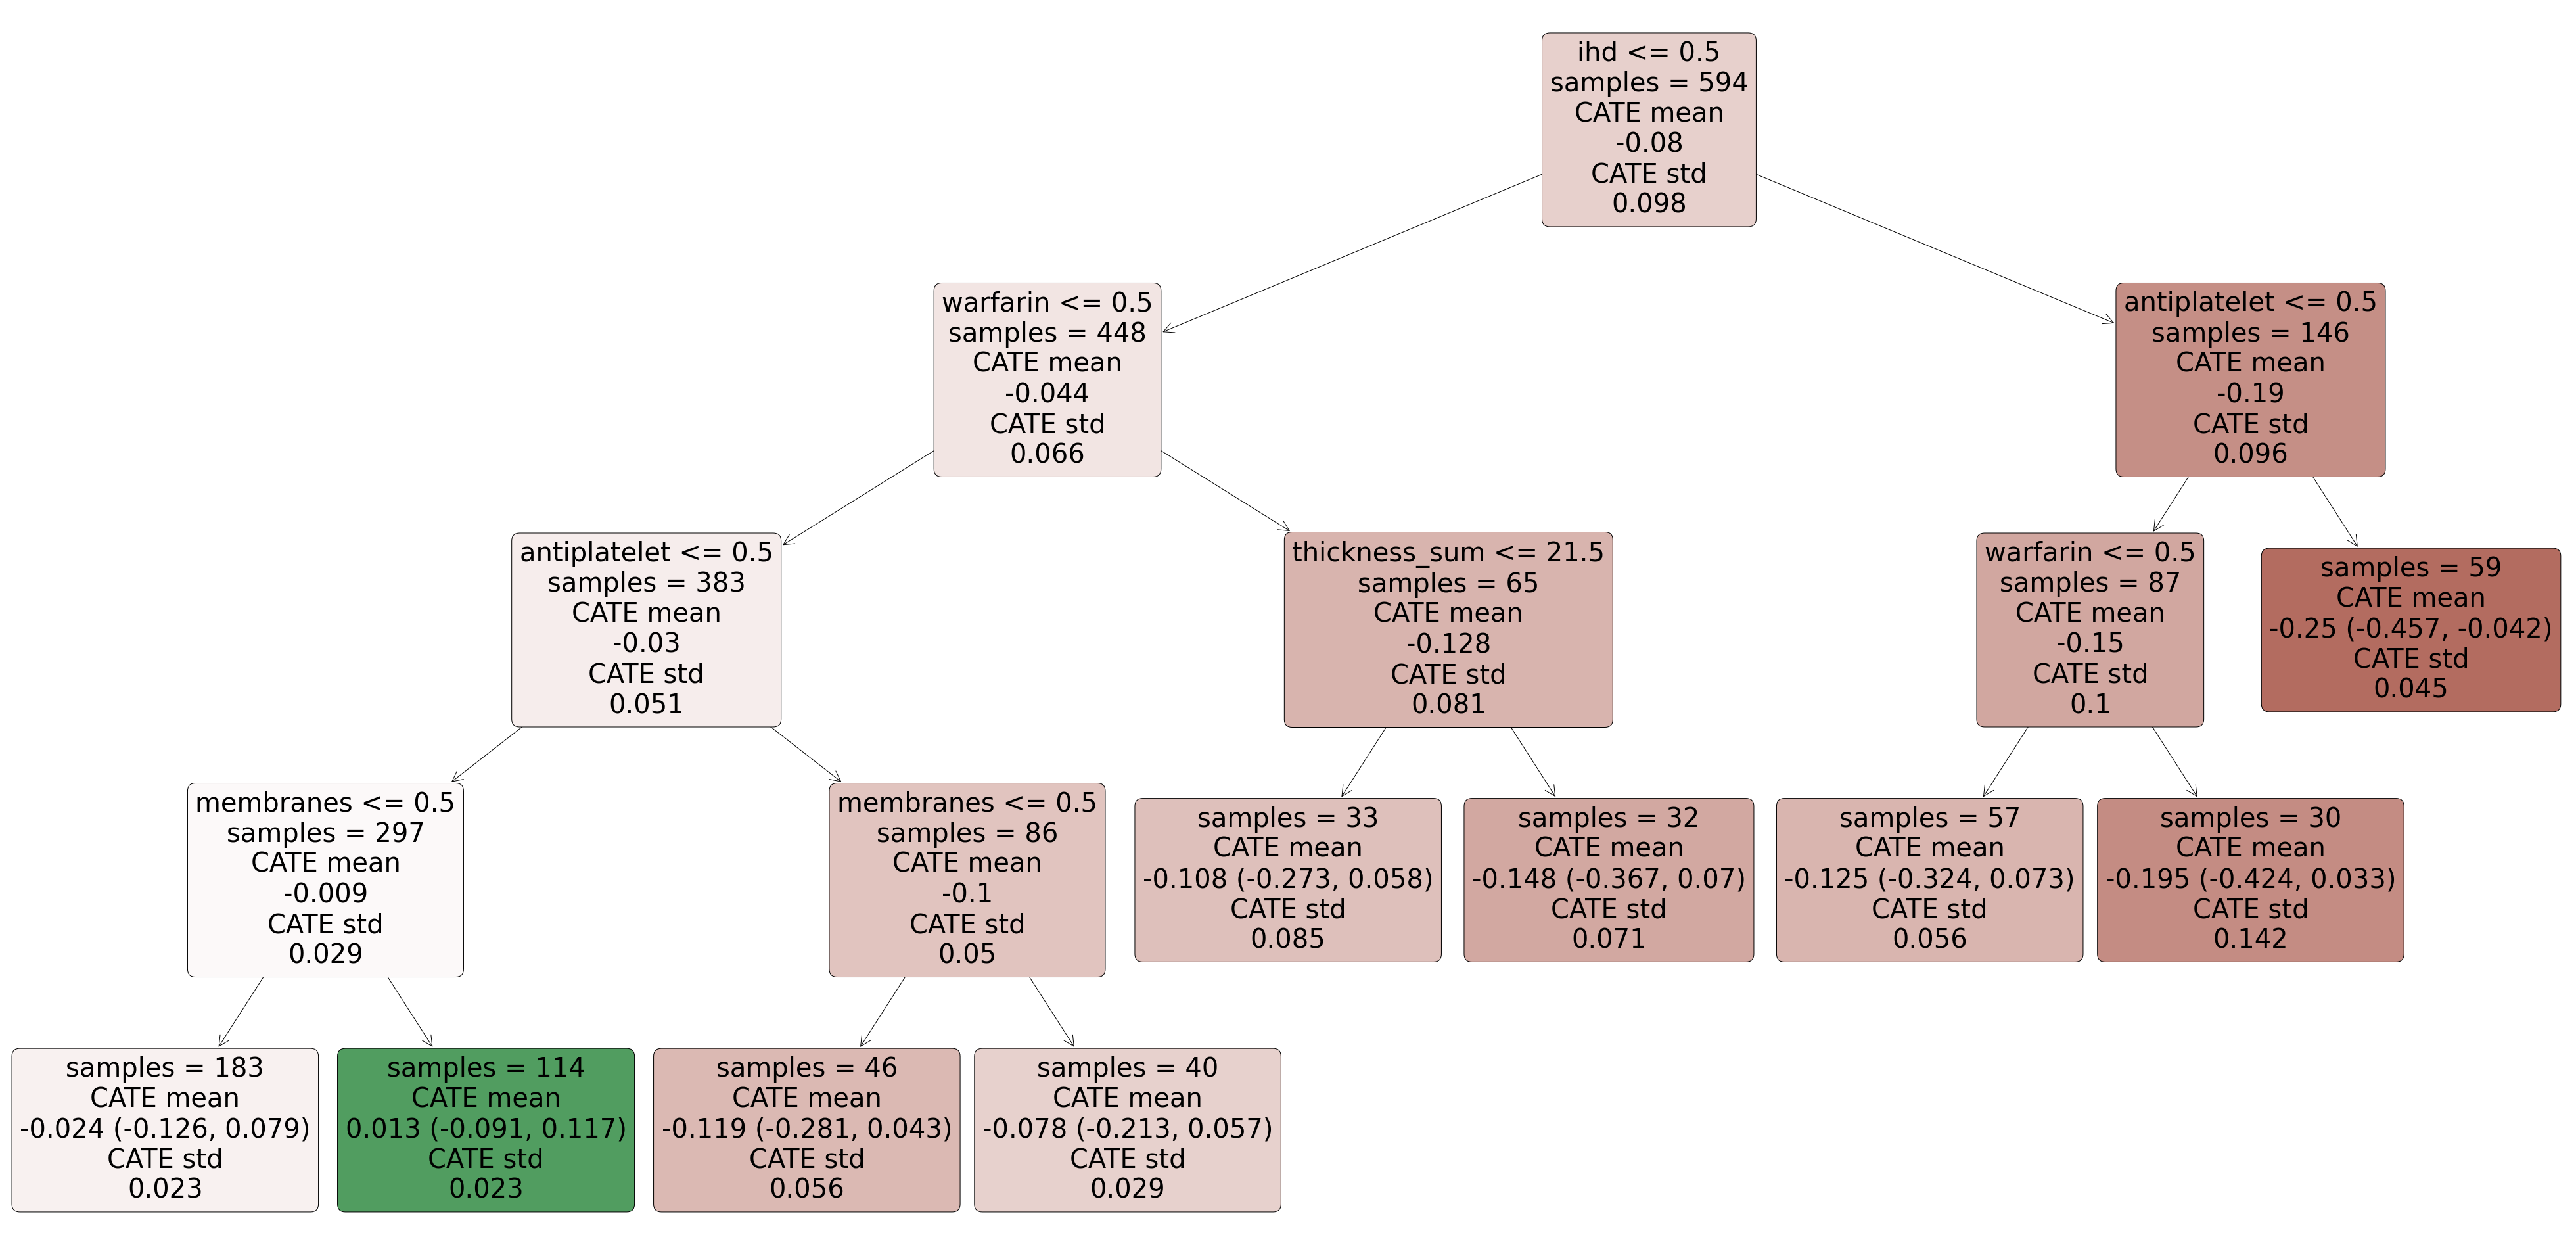

In [31]:
patient_lin_intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=30)
patient_lin_intrp.interpret(patient_linear_dml_est, X)
plt.figure(figsize=(70, 35))
patient_lin_intrp.plot(feature_names=p_conditions, fontsize=40)
plt.savefig('../output/figs/patient_cate_tree.png', dpi=300)